# 

In [1]:
pip install numpy pandas joblib matplotlib seaborn scikit-learn fasttext-wheel tensorflow tensorflow-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
umap-

In [3]:
# UniEmbed ML Training (Notebook version)
# Detect XSS & SQL Injection payloads using MLP, RandomForest, SVM, and Voting classifiers.
# Uses Word2Vec + FastText + Universal Sentence Encoder (USE)

# Nếu cần cài thêm package (chỉ chạy 1 lần)
# !pip install pandas numpy scikit-learn gensim fasttext tensorflow tensorflow_hub matplotlib seaborn joblib

import os
import re
import time
import warnings
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

import gensim
from gensim.models import KeyedVectors
import fasttext
import tensorflow_hub as hub
import tensorflow as tf

warnings.filterwarnings("ignore", category=UserWarning)
sns.set(style="whitegrid")

2025-11-10 18:53:06.758755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762800787.100286      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762800787.188405      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


2025-11-10 18:53:25.197055: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# def clean_text(s: str) -> str:
#     """Làm sạch payload: bỏ HTML, ký tự lạ, chuẩn hóa khoảng trắng, lowercase."""
#     if s is None:
#         return ""
#     s = re.sub(r"<[^>]+>", " ", s)
#     s = re.sub(r"[\r\n\t]", " ", s)
#     s = re.sub(r"[^a-zA-Z0-9_\-\.\,\:\;\(\)\[\]\{\}\'\"\@\!\?\=\+\*\%\/\\\|\s]", " ", s)
#     s = re.sub(r"\s+", " ", s).strip().lower()
#     return s

def clean_text(s: str) -> str:
    """Clean payload text: giữ lại các ký tự quan trọng cho XSS/SQLi."""
    if s is None:
        return ""
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[\r\n\t]", " ", s)
    s = re.sub(r"[^a-zA-Z0-9()'"";=&|!?+*%\-_@\\|\s]", " ", s) 
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s


def tokenize(s: str) -> List[str]:
    """Token hóa đơn giản theo dấu cách."""
    return s.split() if s else []


In [6]:
# def load_word2vec(path: str) -> KeyedVectors:
#     print(f"[INFO] Loading Word2Vec from: {path}")
#     kv = KeyedVectors.load_word2vec_format(path, binary=True, mmap='r')
#     print("[INFO] Word2Vec loaded.")
#     return kv

def load_word2vec(path: str) -> KeyedVectors:
    print(f"[INFO] Loading Word2Vec from: {path}")
    kv = KeyedVectors.load_word2vec_format(path, binary=True)
    print("[INFO] Word2Vec loaded.")
    return kv

def load_fasttext(path: str):
    print(f"[INFO] Loading FastText from: {path}")
    ft = fasttext.load_model(path)
    print("[INFO] FastText loaded.")
    return ft

def load_use():
    """Load Universal Sentence Encoder (USE)."""
    print("[INFO] Loading USE model from TensorFlow Hub ...")
    use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    print("[INFO] USE loaded.")
    return use_model


In [7]:
def sentence_embedding_w2v(tokens: List[str], kv: KeyedVectors) -> np.ndarray:
    """Vector trung bình từ Word2Vec (bỏ OOV)."""
    vecs = [kv[t] for t in tokens if t in kv.key_to_index]
    if not vecs:
        return np.zeros(kv.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def sentence_embedding_fasttext(text: str, ft_model) -> np.ndarray:
    """Vector FastText 300-d."""
    return ft_model.get_sentence_vector(text).astype(np.float32)

def sentence_embedding_use(use_model, texts: List[str], batch_size: int = 128) -> np.ndarray:
    """Batch USE để tránh OOM."""
    out = []
    for i in range(0, len(texts), batch_size):
        out.append(use_model(texts[i:i+batch_size]).numpy())
    return np.vstack(out).astype(np.float32)

def fit_pca_for_projection(sentences: List[str], kv, ft_model, n_components=100):
    cleaned = [clean_text(s) for s in sentences]
    tokens_list = [tokenize(c) for c in cleaned]
    w2v_raw = np.vstack([sentence_embedding_w2v(t, kv) for t in tokens_list])
    ft_raw = np.vstack([sentence_embedding_fasttext(c, ft_model) for c in cleaned])
    pca_w2v = PCA(n_components=n_components, random_state=42).fit(w2v_raw)
    pca_ft = PCA(n_components=n_components, random_state=42).fit(ft_raw)
    return pca_w2v, pca_ft

def build_uniembed_features(sentences, kv, ft_model, use_model, pca_w2v, pca_ft, batch_size=128):
    cleaned = [clean_text(s) for s in sentences]
    tokens_list = [tokenize(c) for c in cleaned]
    w2v_100 = pca_w2v.transform(np.vstack([sentence_embedding_w2v(t, kv) for t in tokens_list]))
    ft_100 = pca_ft.transform(np.vstack([sentence_embedding_fasttext(c, ft_model) for c in cleaned]))
    use_512 = sentence_embedding_use(use_model, cleaned, batch_size=batch_size)
    return np.hstack([w2v_100, ft_100, use_512]).astype(np.float32)


In [8]:
def compute_metrics(y_true, y_pred, y_score=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        metrics["roc_auc"] = auc(fpr, tpr)
    return metrics

def plot_confusion(y_true, y_pred, title, out_path=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
    plt.show()

def plot_roc(y_true, y_score, title, out_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
    plt.show()


In [9]:
def train_models(X_train, X_test, y_train, y_test):
    # os.makedirs(out_dir, exist_ok=True)
    models = {
        "mlp": MLPClassifier(hidden_layer_sizes=(256,128), activation="relu", solver="adam",
                             max_iter=200, early_stopping=True, random_state=42),
        "rf": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
        "svm": SVC(kernel="rbf", C=3.0, gamma="scale", probability=True, random_state=42),
    }

    all_metrics = []
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n[INFO] Training {name.upper()} ...")
        t0 = time.time()
        model.fit(X_train, y_train)
        t1 = time.time() - t0
        
        trained_models[name] = model

        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        m = compute_metrics(y_test, y_pred, y_score)
        m["model"] = name
        m["train_time_sec"] = t1
        all_metrics.append(m)

        # joblib.dump(model, f"{out_dir}/{name}.pkl", compress=3)
        print(f"→ Saved {name}.pkl | Acc={m['accuracy']:.4f}, F1={m['f1']:.4f}")

        plot_confusion(y_test, y_pred, f"Confusion Matrix — {name}")
        if y_score is not None:
            plot_roc(y_test, y_score, f"ROC Curve — {name}")

    # Voting
    voting = VotingClassifier([(k, models[k]) for k in models], voting="soft", n_jobs=-1)
    voting.fit(X_train, y_train)
    trained_models["voting_soft"] = voting
    
    y_pred = voting.predict(X_test)
    y_score = voting.predict_proba(X_test)[:, 1]
    m = compute_metrics(y_test, y_pred, y_score)
    m["model"] = "voting_soft"
    all_metrics.append(m)

    print(f"\n→ Saved voting_soft.pkl | Acc={m['accuracy']:.4f}, F1={m['f1']:.4f}")
    plot_confusion(y_test, y_pred, "Confusion Matrix — Voting (Soft)")
    plot_roc(y_test, y_score, "ROC Curve — Voting (Soft)")

    return pd.DataFrame(all_metrics), trained_models


# **DATASET XSS**

                                            Sentence  Label
0  <li><a href="/wiki/File:Socrates.png" class="i...      0
1               <tt onmouseover="alert(1)">test</tt>      1
2  \t </span> <span class="reference-text">Steeri...      0
3  \t </span> <span class="reference-text"><cite ...      0
4  \t </span>. <a href="/wiki/Digital_object_iden...      0
[INFO] Loading USE model from TensorFlow Hub ...
[INFO] USE loaded.
[INFO] Loading Word2Vec from: /kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin
[INFO] Word2Vec loaded.
[INFO] Loading FastText from: /kaggle/input/nt213-uit/cc.en.300.bin
[INFO] FastText loaded.
[INFO] Fitting PCA ...


[INFO] Building UniEmbed features ...

[INFO] Training MLP ...
→ Saved mlp.pkl | Acc=0.8860, F1=0.8818


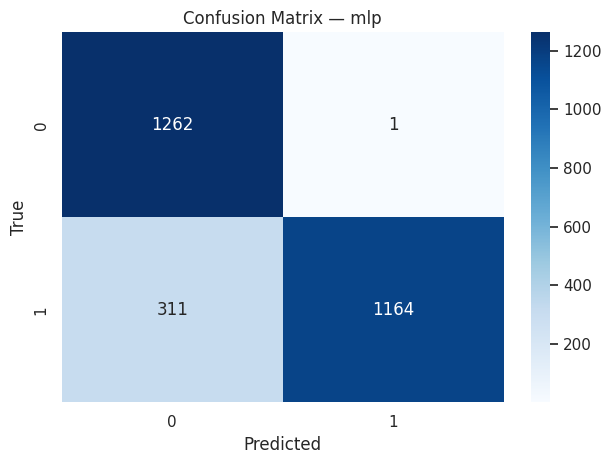

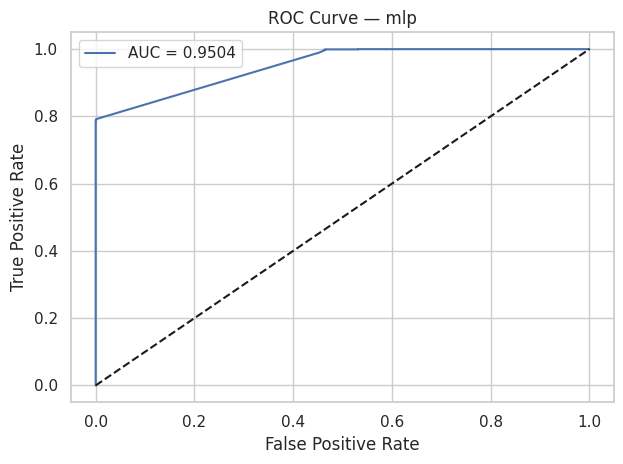


[INFO] Training RF ...
→ Saved rf.pkl | Acc=0.8831, F1=0.8785


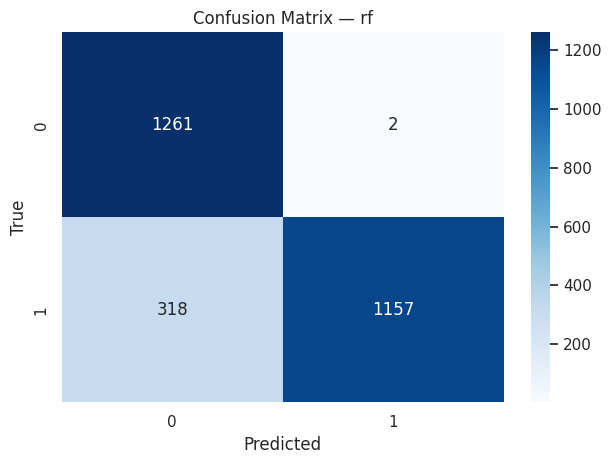

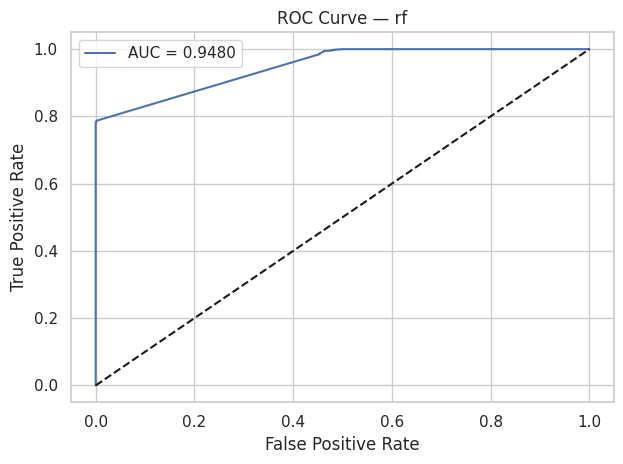


[INFO] Training SVM ...
→ Saved svm.pkl | Acc=0.8857, F1=0.8813


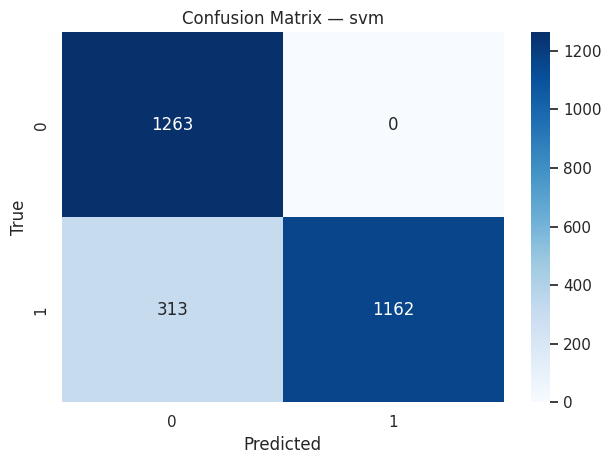

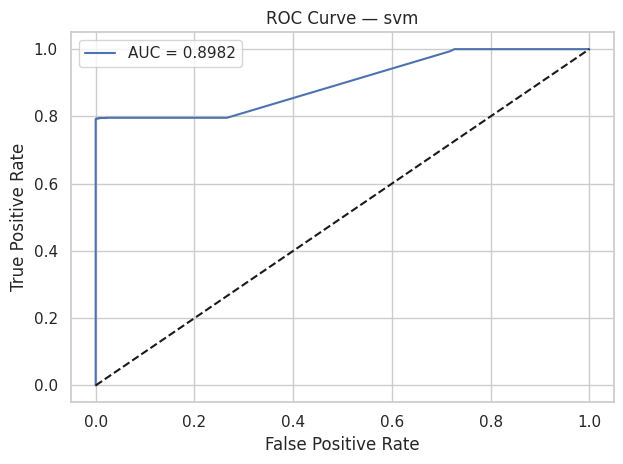


→ Saved voting_soft.pkl | Acc=0.8868, F1=0.8827


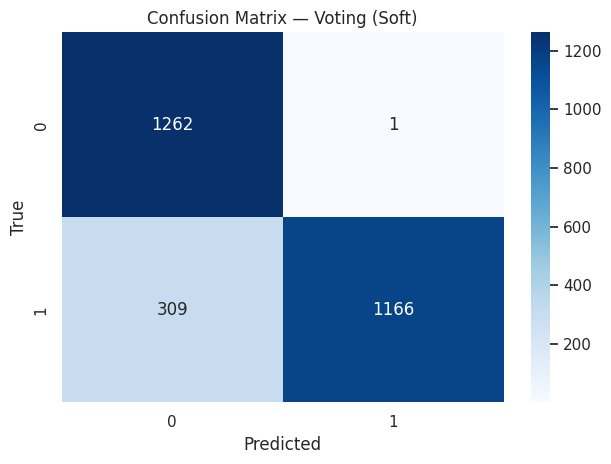

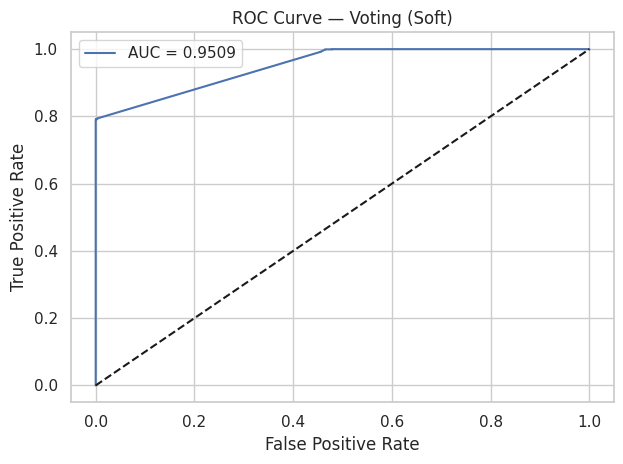

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,accuracy,precision,recall,f1,roc_auc,model,train_time_sec
0,0.886048,0.999142,0.789153,0.881818,0.950366,mlp,4.452199
1,0.883126,0.998274,0.784407,0.878512,0.947970,rf,11.101083
2,0.885683,1.000000,0.787797,0.881305,0.898150,svm,153.602728
3,0.886779,0.999143,0.790508,0.882665,0.950859,voting_soft,NaN


[INFO] Saving all results to: /kaggle/working/output_XSS_dataset1_20251110_190156
[INFO] ✅ All outputs saved under: /kaggle/working/output_XSS_dataset1_20251110_190156


In [10]:
# === THÔNG SỐ NGƯỜI DÙNG ===
data_path = "/kaggle/input/xssdataset1/XSS_dataset1.csv"       # CSV chứa cột Sentence, Label
w2v_path = "/kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin"
ft_path  = "/kaggle/input/nt213-uit/cc.en.300.bin"
test_size = 0.2
random_state = 42

# === LOAD DATA ===
df = pd.read_csv(data_path, encoding='utf-8')
print(df.head())

sentences = df["Sentence"].astype(str).tolist()
labels = df["Label"].astype(int).values

X_train_s, X_test_s, y_train, y_test = train_test_split(
    sentences, labels, test_size=test_size, random_state=random_state, stratify=labels
)

# === LOAD MODELS ===
use_model = load_use()
w2v_kv = load_word2vec(w2v_path)
ft_model = load_fasttext(ft_path)

# === PCA FIT & FEATURE BUILD ===
print("[INFO] Fitting PCA ...")
pca_w2v, pca_ft = fit_pca_for_projection(X_train_s, w2v_kv, ft_model)

print("[INFO] Building UniEmbed features ...")
X_train = build_uniembed_features(X_train_s, w2v_kv, ft_model, use_model, pca_w2v, pca_ft)
X_test  = build_uniembed_features(X_test_s,  w2v_kv, ft_model, use_model, pca_w2v, pca_ft)

# === SCALE ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === TRAIN ===
metrics_df, trained_models = train_models(X_train, X_test, y_train, y_test)
display(metrics_df)

# === SAVE OUTPUTS ===
import os, joblib, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# === THƯ MỤC LƯU ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = os.path.splitext(os.path.basename(data_path))[0]  # lấy tên file dataset
base_dir = f"/kaggle/working/output_{run_name}_{timestamp}"
os.makedirs(base_dir, exist_ok=True)
print(f"[INFO] Saving all results to: {base_dir}")

# === 1️⃣ Lưu model, scaler, PCA ===
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# nếu train_models trả về dict model, lưu từng model
try:
    for name, model in trained_models.items():
        joblib.dump(model, f"{model_dir}/{name}.pkl", compress=3)
except Exception as e:
    print("[WARN] Không thấy biến trained_models, chỉ lưu scaler & PCA.")
    
joblib.dump(scaler, f"{model_dir}/scaler.joblib")
joblib.dump(pca_w2v, f"{model_dir}/pca_w2v.joblib")
joblib.dump(pca_ft, f"{model_dir}/pca_ft.joblib")

# === 2️⃣ Lưu metrics summary ===
metrics_path = os.path.join(base_dir, "metrics_summary.csv")
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8")

# === 3️⃣ Tạo dự đoán & báo cáo chi tiết ===
# (nếu bạn có mô hình cuối hoặc mô hình ensemble)
if 'voting_clf' in globals():
    final_model = voting_clf
elif 'clf_best' in globals():
    final_model = clf_best
else:
    final_model = None

if final_model is not None:
    y_pred = final_model.predict(X_test)
    if hasattr(final_model, "predict_proba"):
        y_prob = final_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Báo cáo chi tiết
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(os.path.join(base_dir, "classification_report.csv"))
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "confusion_matrix.png"))
    plt.close()

    # ROC & PR Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(base_dir, "roc_curve.png"))
        plt.close()

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(5,5))
        plt.plot(recall, precision)
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig(os.path.join(base_dir, "pr_curve.png"))
        plt.close()

    # Lưu dự đoán chi tiết (test sentences)
    preds_df = pd.DataFrame({
        "Sentence": X_test_s,
        "TrueLabel": y_test,
        "PredLabel": y_pred,
    })
    if y_prob is not None:
        preds_df["Prob"] = y_prob
    preds_df.to_csv(os.path.join(base_dir, "predictions_test.csv"), index=False, encoding="utf-8")

# === 4️⃣ Lưu metadata (thông tin cấu hình run) ===
meta = {
    "dataset": run_name,
    "data_path": data_path,
    "test_size": test_size,
    "random_state": random_state,
    "timestamp": timestamp,
    "w2v_path": w2v_path,
    "ft_path": ft_path,
}
with open(os.path.join(base_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"[INFO] ✅ All outputs saved under: {base_dir}")


# **DATASET SQLi**

In [11]:
data_path = "/kaggle/input/nt213-uit/sqli.csv"
for enc in ['utf-8', 'utf-8-sig', 'utf-16', 'utf-16le', 'utf-16be', 'latin1', 'cp1252']:
    try:
        df = pd.read_csv(data_path, encoding=enc)
        print(f"[INFO] Đọc file thành công với encoding = {enc}")
        print(df.head())
        break
    except Exception as e:
        print(f"[WARN] Thử {enc} lỗi:", str(e)[:80])

[WARN] Thử utf-8 lỗi: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
[WARN] Thử utf-8-sig lỗi: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
[INFO] Đọc file thành công với encoding = utf-16
          Sentence  Label
0                a      1
1              a'       1
2            a' --      1
3  a' or 1 = 1; --      1
4                @      1


          Sentence  Label
0                a      1
1              a'       1
2            a' --      1
3  a' or 1 = 1; --      1
4                @      1
[INFO] Loading USE model from TensorFlow Hub ...
[INFO] USE loaded.
[INFO] Loading Word2Vec from: /kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin
[INFO] Word2Vec loaded.
[INFO] Loading FastText from: /kaggle/input/nt213-uit/cc.en.300.bin
[INFO] FastText loaded.


[INFO] Fitting PCA ...
[INFO] Building UniEmbed features ...

[INFO] Training MLP ...
→ Saved mlp.pkl | Acc=0.9905, F1=0.9821


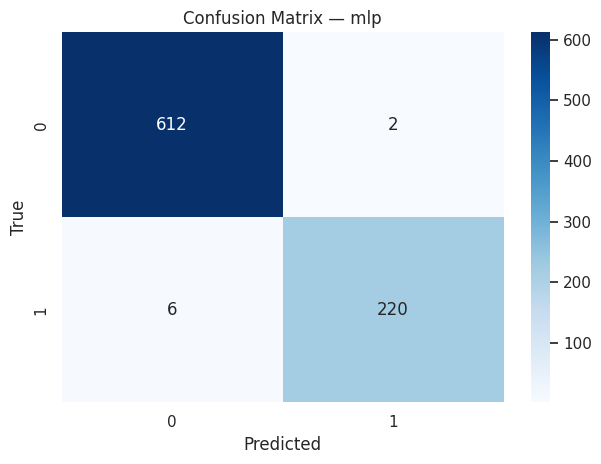

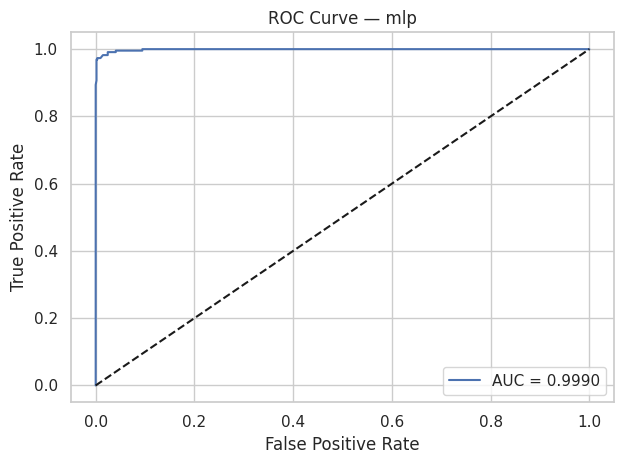


[INFO] Training RF ...
→ Saved rf.pkl | Acc=0.9881, F1=0.9776


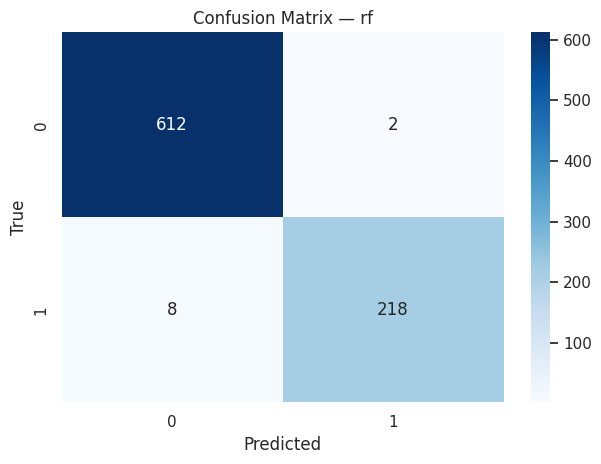

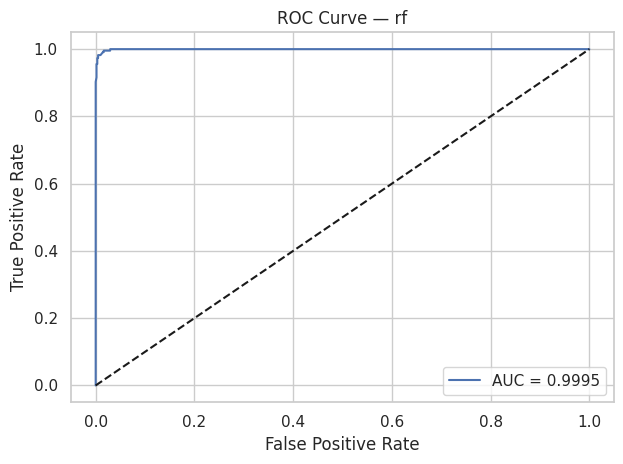


[INFO] Training SVM ...
→ Saved svm.pkl | Acc=0.9893, F1=0.9800


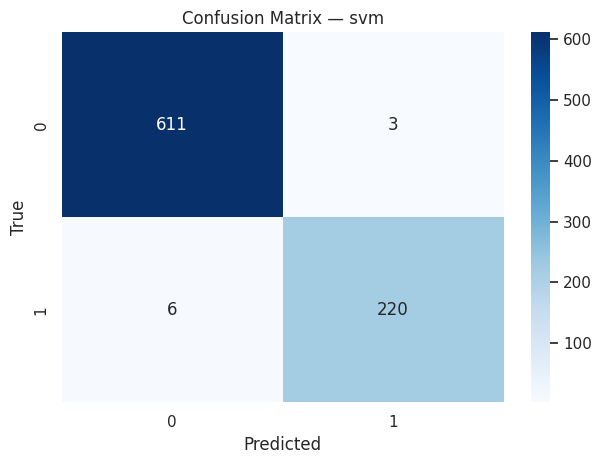

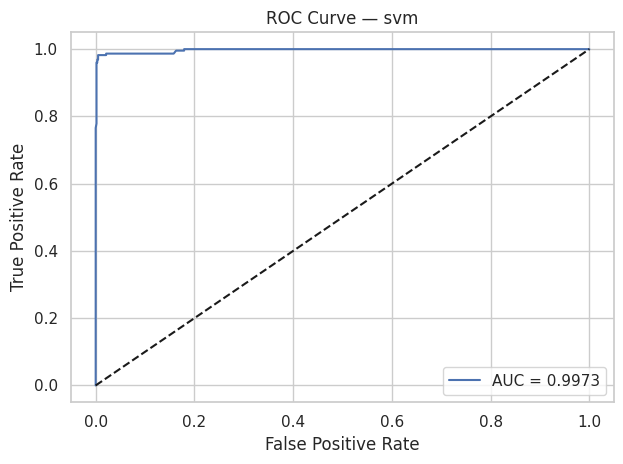


→ Saved voting_soft.pkl | Acc=0.9881, F1=0.9777


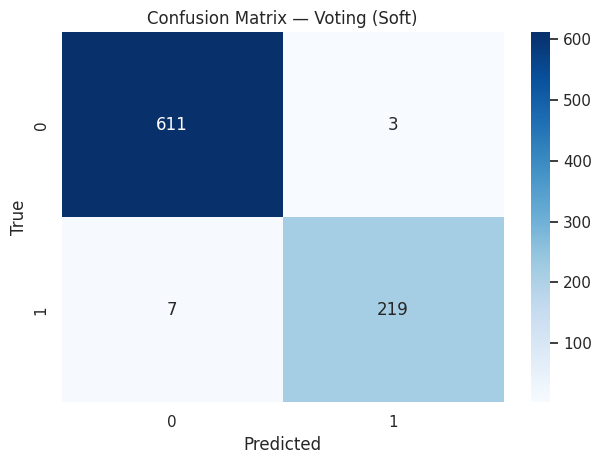

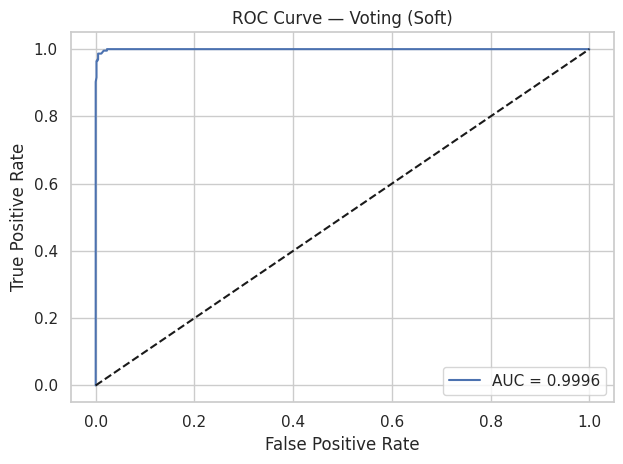

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,accuracy,precision,recall,f1,roc_auc,model,train_time_sec
0,0.990476,0.990991,0.973451,0.982143,0.998951,mlp,1.371851
1,0.988095,0.990909,0.964602,0.977578,0.999514,rf,8.833390
2,0.989286,0.986547,0.973451,0.979955,0.997294,svm,8.031672
3,0.988095,0.986486,0.969027,0.977679,0.999586,voting_soft,NaN


[INFO] Saving all results to: /kaggle/working/output_sqli_20251110_190433
[INFO] ✅ All outputs saved under: /kaggle/working/output_sqli_20251110_190433


In [12]:
# === THÔNG SỐ NGƯỜI DÙNG ===
data_path = "/kaggle/input/nt213-uit/sqli.csv"       # CSV chứa cột Sentence, Label
w2v_path = "/kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin"
ft_path  = "/kaggle/input/nt213-uit/cc.en.300.bin"
test_size = 0.2

# === LOAD DATA ===
df = pd.read_csv(data_path, encoding='utf-16')
print(df.head())

sentences = df["Sentence"].astype(str).tolist()
labels = df["Label"].astype(int).values

X_train_s, X_test_s, y_train, y_test = train_test_split(
    sentences, labels, test_size=test_size, random_state=random_state, stratify=labels
)

# === LOAD MODELS ===
use_model = load_use()
w2v_kv = load_word2vec(w2v_path)
ft_model = load_fasttext(ft_path)

# === PCA FIT & FEATURE BUILD ===
print("[INFO] Fitting PCA ...")
pca_w2v, pca_ft = fit_pca_for_projection(X_train_s, w2v_kv, ft_model)

print("[INFO] Building UniEmbed features ...")
X_train = build_uniembed_features(X_train_s, w2v_kv, ft_model, use_model, pca_w2v, pca_ft)
X_test  = build_uniembed_features(X_test_s,  w2v_kv, ft_model, use_model, pca_w2v, pca_ft)

# === SCALE ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === TRAIN ===
metrics_df, trained_models = train_models(X_train, X_test, y_train, y_test)
display(metrics_df)

# === SAVE OUTPUTS ===
import os, joblib, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# === THƯ MỤC LƯU ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = os.path.splitext(os.path.basename(data_path))[0]  # lấy tên file dataset
base_dir = f"/kaggle/working/output_{run_name}_{timestamp}"
os.makedirs(base_dir, exist_ok=True)
print(f"[INFO] Saving all results to: {base_dir}")

# === 1️⃣ Lưu model, scaler, PCA ===
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# nếu train_models trả về dict model, lưu từng model
try:
    for name, model in trained_models.items():
        joblib.dump(model, f"{model_dir}/{name}.joblib")
except Exception as e:
    print("[WARN] Không thấy biến trained_models, chỉ lưu scaler & PCA.")
    
joblib.dump(scaler, f"{model_dir}/scaler.joblib")
joblib.dump(pca_w2v, f"{model_dir}/pca_w2v.joblib")
joblib.dump(pca_ft, f"{model_dir}/pca_ft.joblib")

# === 2️⃣ Lưu metrics summary ===
metrics_path = os.path.join(base_dir, "metrics_summary.csv")
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8")

# === 3️⃣ Tạo dự đoán & báo cáo chi tiết ===
# (nếu bạn có mô hình cuối hoặc mô hình ensemble)
if 'voting_clf' in globals():
    final_model = voting_clf
elif 'clf_best' in globals():
    final_model = clf_best
else:
    final_model = None

if final_model is not None:
    y_pred = final_model.predict(X_test)
    if hasattr(final_model, "predict_proba"):
        y_prob = final_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Báo cáo chi tiết
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(os.path.join(base_dir, "classification_report.csv"))
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "confusion_matrix.png"))
    plt.close()

    # ROC & PR Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(base_dir, "roc_curve.png"))
        plt.close()

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(5,5))
        plt.plot(recall, precision)
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig(os.path.join(base_dir, "pr_curve.png"))
        plt.close()

    # Lưu dự đoán chi tiết (test sentences)
    preds_df = pd.DataFrame({
        "Sentence": X_test_s,
        "TrueLabel": y_test,
        "PredLabel": y_pred,
    })
    if y_prob is not None:
        preds_df["Prob"] = y_prob
    preds_df.to_csv(os.path.join(base_dir, "predictions_test.csv"), index=False, encoding="utf-8")

# === 4️⃣ Lưu metadata (thông tin cấu hình run) ===
meta = {
    "dataset": run_name,
    "data_path": data_path,
    "test_size": test_size,
    "random_state": random_state,
    "timestamp": timestamp,
    "w2v_path": w2v_path,
    "ft_path": ft_path,
}
with open(os.path.join(base_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"[INFO] ✅ All outputs saved under: {base_dir}")


# **DATASET SQLiV2**

In [13]:
data_path = "/kaggle/input/nt213-uit/sqliv2.csv"
for enc in ['utf-8', 'utf-8-sig', 'utf-16', 'utf-16le', 'utf-16be', 'latin1', 'cp1252']:
    try:
        df = pd.read_csv(data_path, encoding=enc)
        print(f"[INFO] Đọc file thành công với encoding = {enc}")
        print(df.head())
        break
    except Exception as e:
        print(f"[WARN] Thử {enc} lỗi:", str(e)[:80])

[WARN] Thử utf-8 lỗi: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
[WARN] Thử utf-8-sig lỗi: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
[INFO] Đọc file thành công với encoding = utf-16
                                            Sentence  Label
0                                                NaN      1
1                      " or pg_sleep ( __TIME__ ) --      1
2  create user name identified by pass123 tempora...      1
3                                                %29      1
4  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1


                                            Sentence  Label
0                                                NaN      1
1                      " or pg_sleep ( __TIME__ ) --      1
2  create user name identified by pass123 tempora...      1
3                                                %29      1
4  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1
[INFO] Loading USE model from TensorFlow Hub ...
[INFO] USE loaded.
[INFO] Loading Word2Vec from: /kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin
[INFO] Word2Vec loaded.
[INFO] Loading FastText from: /kaggle/input/nt213-uit/cc.en.300.bin
[INFO] FastText loaded.


[INFO] Fitting PCA ...
[INFO] Building UniEmbed features ...

[INFO] Training MLP ...
→ Saved mlp.pkl | Acc=0.9976, F1=0.9965


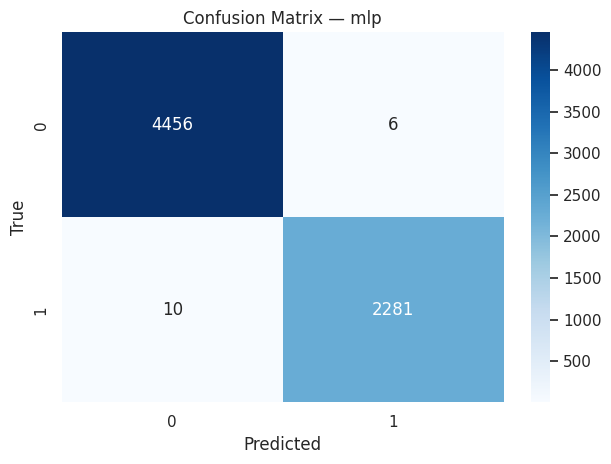

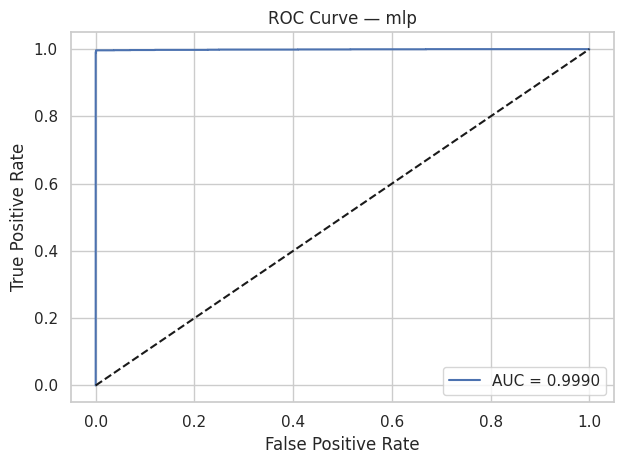


[INFO] Training RF ...
→ Saved rf.pkl | Acc=0.9964, F1=0.9947


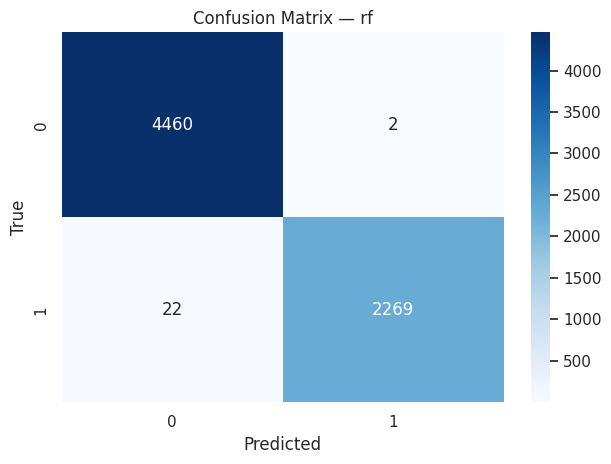

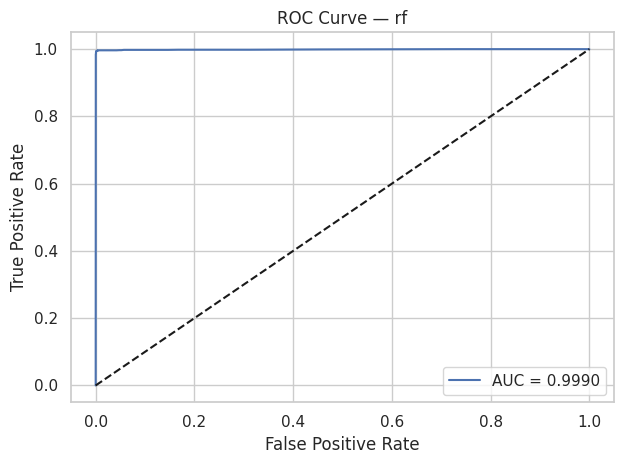


[INFO] Training SVM ...
→ Saved svm.pkl | Acc=0.9979, F1=0.9969


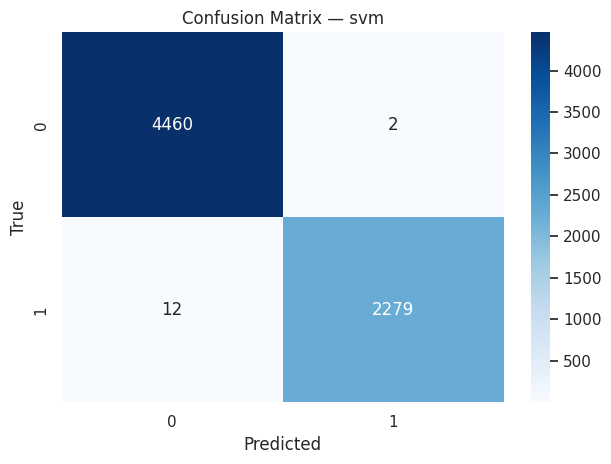

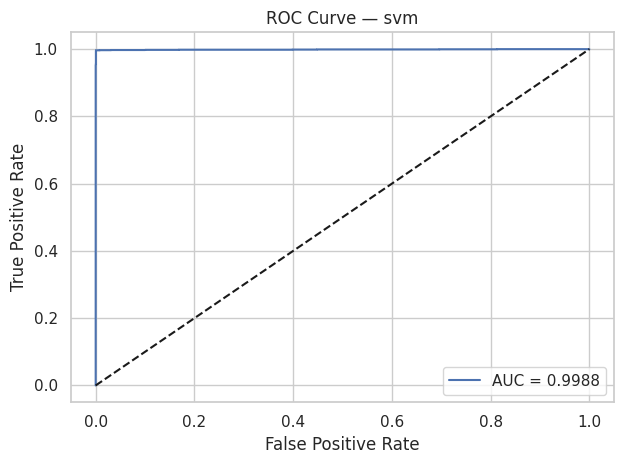


→ Saved voting_soft.pkl | Acc=0.9979, F1=0.9969


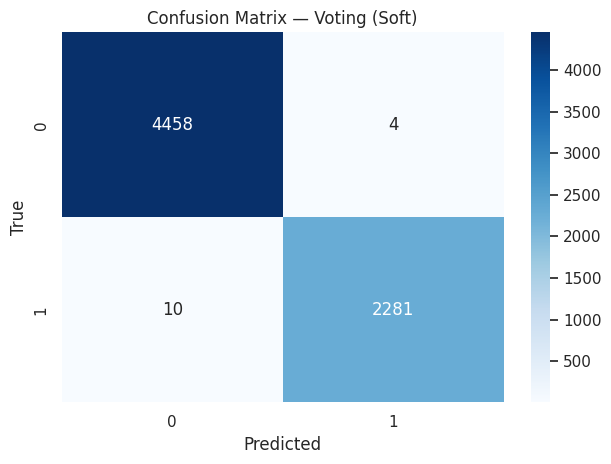

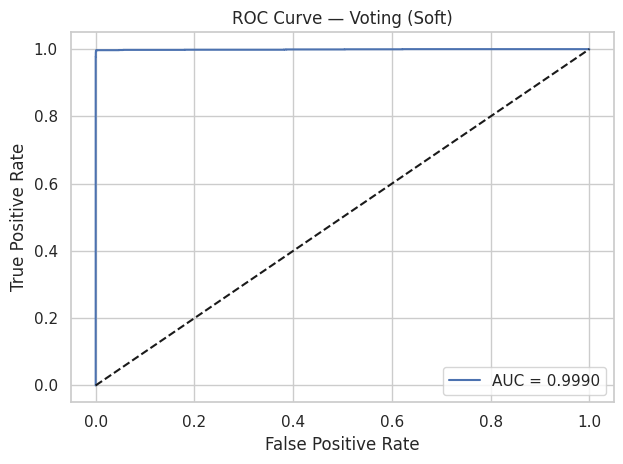

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,accuracy,precision,recall,f1,roc_auc,model,train_time_sec
0,0.997631,0.997376,0.995635,0.996505,0.998993,mlp,20.395754
1,0.996446,0.999119,0.990397,0.994739,0.999014,rf,129.677506
2,0.997927,0.999123,0.994762,0.996938,0.998818,svm,359.181138
3,0.997927,0.998249,0.995635,0.996941,0.999042,voting_soft,NaN


[INFO] Saving all results to: /kaggle/working/output_sqliv2_20251110_192344
[INFO] ✅ All outputs saved under: /kaggle/working/output_sqliv2_20251110_192344


In [14]:
# === THÔNG SỐ NGƯỜI DÙNG ===
data_path = "/kaggle/input/nt213-uit/sqliv2.csv"       # CSV chứa cột Sentence, Label
w2v_path = "/kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin"
ft_path  = "/kaggle/input/nt213-uit/cc.en.300.bin"
test_size = 0.2

# === LOAD DATA ===
df = pd.read_csv(data_path, encoding='utf-16')
print(df.head())

sentences = df["Sentence"].astype(str).tolist()
labels = df["Label"].astype(int).values

X_train_s, X_test_s, y_train, y_test = train_test_split(
    sentences, labels, test_size=test_size, random_state=random_state, stratify=labels
)

# === LOAD MODELS ===
use_model = load_use()
w2v_kv = load_word2vec(w2v_path)
ft_model = load_fasttext(ft_path)

# === PCA FIT & FEATURE BUILD ===
print("[INFO] Fitting PCA ...")
pca_w2v, pca_ft = fit_pca_for_projection(X_train_s, w2v_kv, ft_model)

print("[INFO] Building UniEmbed features ...")
X_train = build_uniembed_features(X_train_s, w2v_kv, ft_model, use_model, pca_w2v, pca_ft)
X_test  = build_uniembed_features(X_test_s,  w2v_kv, ft_model, use_model, pca_w2v, pca_ft)

# === SCALE ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === TRAIN ===
metrics_df, trained_models = train_models(X_train, X_test, y_train, y_test)
display(metrics_df)

# === SAVE OUTPUTS ===
import os, joblib, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# === THƯ MỤC LƯU ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = os.path.splitext(os.path.basename(data_path))[0]  # lấy tên file dataset
base_dir = f"/kaggle/working/output_{run_name}_{timestamp}"
os.makedirs(base_dir, exist_ok=True)
print(f"[INFO] Saving all results to: {base_dir}")

# === 1️⃣ Lưu model, scaler, PCA ===
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# nếu train_models trả về dict model, lưu từng model
try:
    for name, model in trained_models.items():
        joblib.dump(model, f"{model_dir}/{name}.joblib")
except Exception as e:
    print("[WARN] Không thấy biến trained_models, chỉ lưu scaler & PCA.")
    
joblib.dump(scaler, f"{model_dir}/scaler.joblib")
joblib.dump(pca_w2v, f"{model_dir}/pca_w2v.joblib")
joblib.dump(pca_ft, f"{model_dir}/pca_ft.joblib")

# === 2️⃣ Lưu metrics summary ===
metrics_path = os.path.join(base_dir, "metrics_summary.csv")
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8")

# === 3️⃣ Tạo dự đoán & báo cáo chi tiết ===
# (nếu bạn có mô hình cuối hoặc mô hình ensemble)
if 'voting_clf' in globals():
    final_model = voting_clf
elif 'clf_best' in globals():
    final_model = clf_best
else:
    final_model = None

if final_model is not None:
    y_pred = final_model.predict(X_test)
    if hasattr(final_model, "predict_proba"):
        y_prob = final_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Báo cáo chi tiết
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(os.path.join(base_dir, "classification_report.csv"))
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "confusion_matrix.png"))
    plt.close()

    # ROC & PR Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(base_dir, "roc_curve.png"))
        plt.close()

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(5,5))
        plt.plot(recall, precision)
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig(os.path.join(base_dir, "pr_curve.png"))
        plt.close()

    # Lưu dự đoán chi tiết (test sentences)
    preds_df = pd.DataFrame({
        "Sentence": X_test_s,
        "TrueLabel": y_test,
        "PredLabel": y_pred,
    })
    if y_prob is not None:
        preds_df["Prob"] = y_prob
    preds_df.to_csv(os.path.join(base_dir, "predictions_test.csv"), index=False, encoding="utf-8")

# === 4️⃣ Lưu metadata (thông tin cấu hình run) ===
meta = {
    "dataset": run_name,
    "data_path": data_path,
    "test_size": test_size,
    "random_state": random_state,
    "timestamp": timestamp,
    "w2v_path": w2v_path,
    "ft_path": ft_path,
}
with open(os.path.join(base_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"[INFO] ✅ All outputs saved under: {base_dir}")


# **DATASET SQLiV3**

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


                                            Sentence  Label  Unnamed: 2
0                  " or pg_sleep  (  __TIME__  )  --      1         NaN
1  create user name identified by pass123 tempora...      1         NaN
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1         NaN
3   select * from users where id  =  '1' or @ @1 ...      1         NaN
4   select * from users where id  =  1 or 1#"  ( ...      1         NaN
[INFO] Loading USE model from TensorFlow Hub ...
[INFO] USE loaded.
[INFO] Loading Word2Vec from: /kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin
[INFO] Word2Vec loaded.
[INFO] Loading FastText from: /kaggle/input/nt213-uit/cc.en.300.bin


[INFO] FastText loaded.
[INFO] Fitting PCA ...
[INFO] Building UniEmbed features ...

[INFO] Training MLP ...
→ Saved mlp.pkl | Acc=0.9969, F1=0.9958


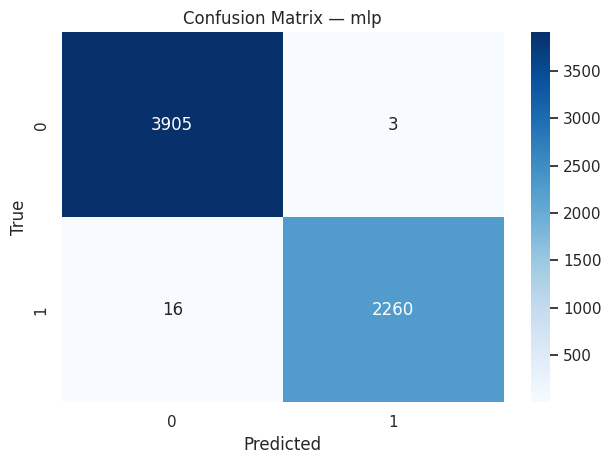

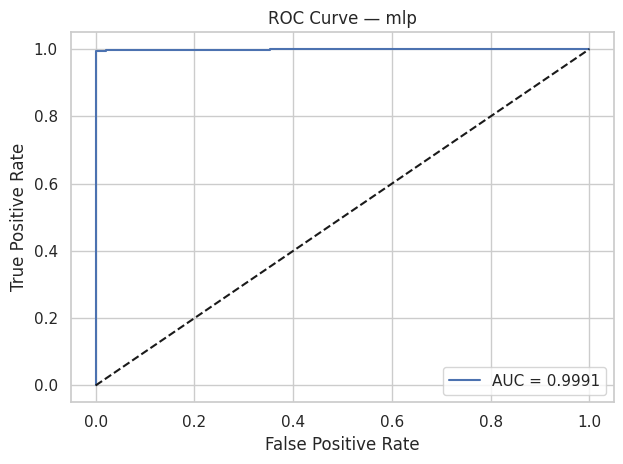


[INFO] Training RF ...
→ Saved rf.pkl | Acc=0.9958, F1=0.9943


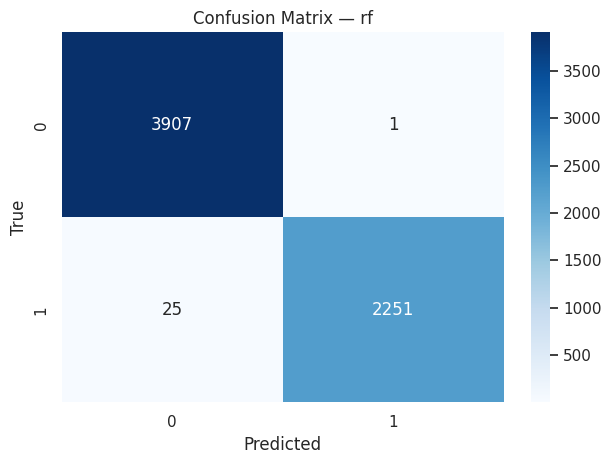

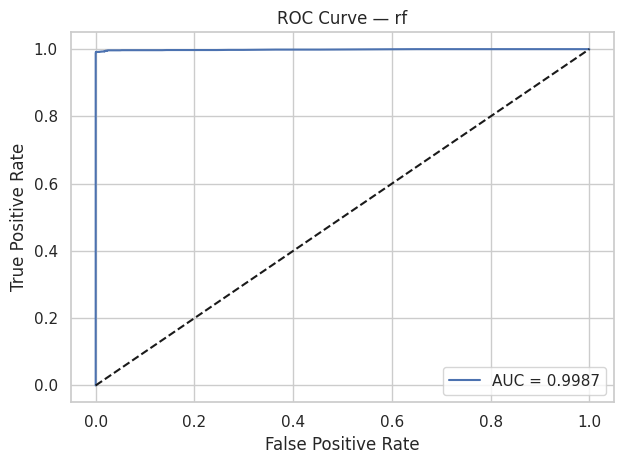


[INFO] Training SVM ...
→ Saved svm.pkl | Acc=0.9971, F1=0.9960


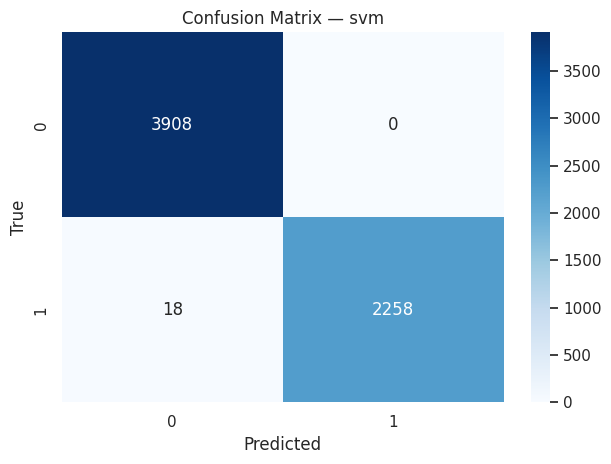

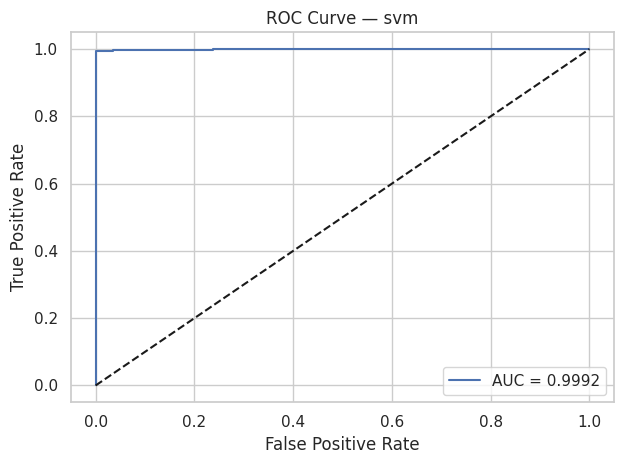


→ Saved voting_soft.pkl | Acc=0.9971, F1=0.9960


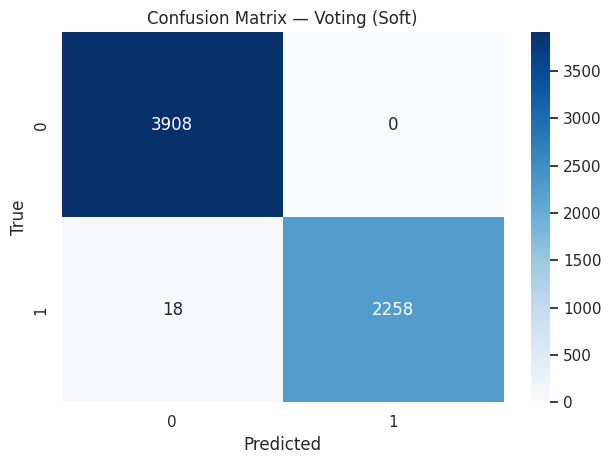

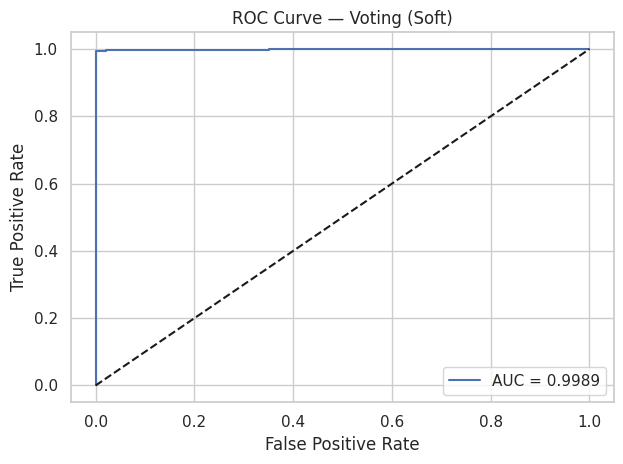

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,accuracy,precision,recall,f1,roc_auc,model,train_time_sec
0,0.996928,0.998674,0.992970,0.995814,0.999121,mlp,11.356461
1,0.995796,0.999556,0.989016,0.994258,0.998705,rf,125.560210
2,0.997089,1.000000,0.992091,0.996030,0.999158,svm,330.145146
3,0.997089,1.000000,0.992091,0.996030,0.998909,voting_soft,NaN


[INFO] Saving all results to: /kaggle/working/output_SQLiV3_1_20251110_194208
[INFO] ✅ All outputs saved under: /kaggle/working/output_SQLiV3_1_20251110_194208


In [15]:
# === THÔNG SỐ NGƯỜI DÙNG ===
data_path = "/kaggle/input/nt213-uit/SQLiV3_1.csv"       # CSV chứa cột Sentence, Label
w2v_path = "/kaggle/input/nt213-uit/GoogleNews-vectors-negative300.bin"
ft_path  = "/kaggle/input/nt213-uit/cc.en.300.bin"
test_size = 0.2

# === LOAD DATA ===
df = pd.read_csv(data_path)
print(df.head())

sentences = df["Sentence"].astype(str).tolist()
labels = df["Label"].astype(int).values

X_train_s, X_test_s, y_train, y_test = train_test_split(
    sentences, labels, test_size=test_size, random_state=random_state, stratify=labels
)

# === LOAD MODELS ===
use_model = load_use()
w2v_kv = load_word2vec(w2v_path)
ft_model = load_fasttext(ft_path)

# === PCA FIT & FEATURE BUILD ===
print("[INFO] Fitting PCA ...")
pca_w2v, pca_ft = fit_pca_for_projection(X_train_s, w2v_kv, ft_model)

print("[INFO] Building UniEmbed features ...")
X_train = build_uniembed_features(X_train_s, w2v_kv, ft_model, use_model, pca_w2v, pca_ft)
X_test  = build_uniembed_features(X_test_s,  w2v_kv, ft_model, use_model, pca_w2v, pca_ft)

# === SCALE ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === TRAIN ===
metrics_df, trained_models = train_models(X_train, X_test, y_train, y_test)
display(metrics_df)

# === SAVE OUTPUTS ===
import os, joblib, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# === THƯ MỤC LƯU ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = os.path.splitext(os.path.basename(data_path))[0]  # lấy tên file dataset
base_dir = f"/kaggle/working/output_{run_name}_{timestamp}"
os.makedirs(base_dir, exist_ok=True)
print(f"[INFO] Saving all results to: {base_dir}")

# === 1️⃣ Lưu model, scaler, PCA ===
model_dir = os.path.join(base_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# nếu train_models trả về dict model, lưu từng model
try:
    for name, model in trained_models.items():
        joblib.dump(model, f"{model_dir}/{name}.joblib")
except Exception as e:
    print("[WARN] Không thấy biến trained_models, chỉ lưu scaler & PCA.")
    
joblib.dump(scaler, f"{model_dir}/scaler.joblib")
joblib.dump(pca_w2v, f"{model_dir}/pca_w2v.joblib")
joblib.dump(pca_ft, f"{model_dir}/pca_ft.joblib")

# === 2️⃣ Lưu metrics summary ===
metrics_path = os.path.join(base_dir, "metrics_summary.csv")
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8")

# === 3️⃣ Tạo dự đoán & báo cáo chi tiết ===
# (nếu bạn có mô hình cuối hoặc mô hình ensemble)
if 'voting_clf' in globals():
    final_model = voting_clf
elif 'clf_best' in globals():
    final_model = clf_best
else:
    final_model = None

if final_model is not None:
    y_pred = final_model.predict(X_test)
    if hasattr(final_model, "predict_proba"):
        y_prob = final_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Báo cáo chi tiết
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(os.path.join(base_dir, "classification_report.csv"))
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "confusion_matrix.png"))
    plt.close()

    # ROC & PR Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(base_dir, "roc_curve.png"))
        plt.close()

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(5,5))
        plt.plot(recall, precision)
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig(os.path.join(base_dir, "pr_curve.png"))
        plt.close()

    # Lưu dự đoán chi tiết (test sentences)
    preds_df = pd.DataFrame({
        "Sentence": X_test_s,
        "TrueLabel": y_test,
        "PredLabel": y_pred,
    })
    if y_prob is not None:
        preds_df["Prob"] = y_prob
    preds_df.to_csv(os.path.join(base_dir, "predictions_test.csv"), index=False, encoding="utf-8")

# === 4️⃣ Lưu metadata (thông tin cấu hình run) ===
meta = {
    "dataset": run_name,
    "data_path": data_path,
    "test_size": test_size,
    "random_state": random_state,
    "timestamp": timestamp,
    "w2v_path": w2v_path,
    "ft_path": ft_path,
}
with open(os.path.join(base_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"[INFO] ✅ All outputs saved under: {base_dir}")
